# Chain of thoughts with RAG

What is Chain-of-Thoughts?

Chain-of-thoughts (CoT) reasoning involves breaking down a problem into smaller, steps, allowing retrieval + reflection at each step before answering.

User Query:
1. Decompose question -> sub-steps (Reason)
2. Retrieve relevant information from context
3. Combine context (Observe)
4. Final answer generation (Reflecz)

In [1]:
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_ollama import ChatOllama
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import Tool, tool, StructuredTool
from langchain_core.documents import Document
from langchain.agents import create_agent
from pydantic import BaseModel
from typing import List

/home/crizz/python/rag_bootcamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
docs = TextLoader(
    "research_notes.txt",
    encoding="utf-8"
).load()

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [3]:
llm = ChatOllama(model="qwen3:4b")

In [4]:
# State
class RAGCOTState(BaseModel):
    question: str
    sub_step: List[str] = []
    retrieved_docs:List[Document] = []
    answer: str = ""    

In [5]:
# Nodes
def plan_steps(state: RAGCOTState) -> RAGCOTState:
    prompt = f"Break the question into 2-3 reasoning steps: \n\n {state.question}"
    result = llm.invoke(prompt).content
    sub_questions = [line.strip("- ") for line in result.split("\n") if line.strip()]
    
    return state.model_copy(update={"sub_step": sub_questions})

In [6]:
def retrieve_per_step(state: RAGCOTState) -> RAGCOTState:
    all_docs = []
    for sub in state.sub_step:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})    

In [7]:
def generate(state: RAGCOTState) -> RAGCOTState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    
    prompt = f"""
        You answering complex question using reasoning and retrieved documents.
        
        Question: {state.question}
        
        Relevant Information:
        {context}
        
        Now synthesize a well-reasoned final answer.    
    """
    
    result = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": result })

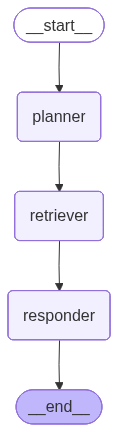

In [8]:
from langgraph.graph import StateGraph, END

builder = StateGraph(RAGCOTState)

builder.add_node("planner", plan_steps)
builder.add_node("retriever", retrieve_per_step)
builder.add_node("responder", generate)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph


In [ ]:
from pprint import pprint

query = "How do agent loops work and why are they useful in AI systems?"
state = RAGCOTState(question=query)
final = graph.invoke(state)

print("\nReasoning Steps:", final["sub_step"])
print("\nFinal Answer:\n", final["answer"])

In [ ]:
from typing import Annotated, TypedDict

state = {
    "messages": Annotated[list[str], "Test"]
}

state['messages'] = ["test"]

state

{'messages': ['test']}